<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Recurrent%20Neural%20Networks%2C%20Time%20Series%2C%20and%20Sequence%20Data/PyTorch_RNN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
class RNN(nn.Module):
    
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0))

        # we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

In [4]:
model = RNN(28, 128, 2, 10)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        # reshape the input
        inputs = inputs.view(-1, 28, 28)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass 
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    
    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1, 28, 28)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    print(f'Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch 1/10, Train Loss: 0.0830, Test Loss: 0.1544
Epoch 2/10, Train Loss: 0.0151, Test Loss: 0.1032
Epoch 3/10, Train Loss: 0.0045, Test Loss: 0.0764
Epoch 4/10, Train Loss: 0.0051, Test Loss: 0.0612
Epoch 5/10, Train Loss: 0.0022, Test Loss: 0.0587
Epoch 6/10, Train Loss: 0.0006, Test Loss: 0.0542
Epoch 7/10, Train Loss: 0.0003, Test Loss: 0.0482
Epoch 8/10, Train Loss: 0.0003, Test Loss: 0.0418
Epoch 9/10, Train Loss: 0.0005, Test Loss: 0.0481
Epoch 10/10, Train Loss: 0.0006, Test Loss: 0.0387


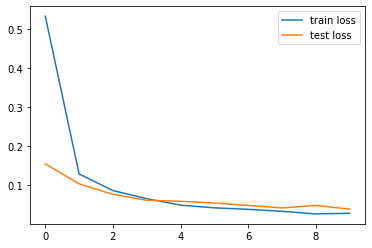

In [10]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [11]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # reshape the input
    inputs = inputs.view(-1, 28, 28)
    
    # Forward pass
    outputs = model(inputs)
    
    # Get predictions
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # reshape the input
    inputs = inputs.view(-1, 28, 28)
    
    # Forward pass
    outputs = model(inputs)
    
    # Get predictions
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9939, Test acc: 0.9880
